In [1]:
!pip install ripser persim torch torchvision --quiet

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 827.3/827.3 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.6/48.6 kB 2.4 MB/s eta 0:00:00


In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from ripser import ripser
from persim import plot_diagrams
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from collections import defaultdict

# Optional in Colab to show plots inline
%matplotlib inline


def make_point_clouds(n_samples_per_shape: int, n_points: int, noise: float):
    """Make point clouds for circles, spheres, and tori with random noise."""
    circle_point_clouds = [
        np.asarray(
            [
                [np.sin(t) + noise * (np.random.rand(1)[0] - 0.5),
                 np.cos(t) + noise * (np.random.rand(1)[0] - 0.5), 0]
                for t in range((n_points ** 2))
            ]
        )
        for kk in range(n_samples_per_shape)
    ]
    circle_labels = np.zeros(n_samples_per_shape)

    sphere_point_clouds = [
        np.asarray(
            [
                [
                    np.cos(s) * np.cos(t) + noise * (np.random.rand(1)[0] - 0.5),
                    np.cos(s) * np.sin(t) + noise * (np.random.rand(1)[0] - 0.5),
                    np.sin(s) + noise * (np.random.rand(1)[0] - 0.5),
                ]
                for t in range(n_points)
                for s in range(n_points)
            ]
        )
        for kk in range(n_samples_per_shape)
    ]
    sphere_labels = np.ones(n_samples_per_shape)

    torus_point_clouds = [
        np.asarray(
            [
                [
                    (2 + np.cos(s)) * np.cos(t) + noise * (np.random.rand(1)[0] - 0.5),
                    (2 + np.cos(s)) * np.sin(t) + noise * (np.random.rand(1)[0] - 0.5),
                    np.sin(s) + noise * (np.random.rand(1)[0] - 0.5),
                ]
                for t in range(n_points)
                for s in range(n_points)
            ]
        )
        for kk in range(n_samples_per_shape)
    ]
    torus_labels = 2 * np.ones(n_samples_per_shape)

    point_clouds = np.concatenate((circle_point_clouds, sphere_point_clouds, torus_point_clouds))
    labels = np.concatenate((circle_labels, sphere_labels, torus_labels))

    return point_clouds, labels


class GiottoPointCloudDataset(Dataset):
    def __init__(self, point_clouds, labels):
        self.data = torch.tensor(point_clouds, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]


class SimplePointMLP(nn.Module):
    """Tiny per-point MLP + global max pooling with layer access."""
    def __init__(self, num_classes):
        super().__init__()
        self.fc1 = nn.Linear(3, 32)
        self.fc2 = nn.Linear(32, 64)
        self.fc3 = nn.Linear(64, 64)
        self.classifier = nn.Sequential(
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, num_classes)
        )
        self.layer_outputs = {}

    def forward(self, x, save_layers=False):
        # x: (B, N, 3)
        if save_layers:
            self.layer_outputs['input'] = x.detach().cpu()

        x = F.relu(self.fc1(x))
        if save_layers:
            self.layer_outputs['fc1'] = x.detach().cpu()

        x = F.relu(self.fc2(x))
        if save_layers:
            self.layer_outputs['fc2'] = x.detach().cpu()

        x = F.relu(self.fc3(x))
        if save_layers:
            self.layer_outputs['fc3'] = x.detach().cpu()

        # Global max pooling across points
        x = x.max(dim=1)[0]  # (B, 64)
        if save_layers:
            self.layer_outputs['pooled'] = x.detach().cpu()

        out = self.classifier(x)
        if save_layers:
            self.layer_outputs['output'] = out.detach().cpu()

        return out


class SimplePointCNN(nn.Module):
    """Tiny PointNet-like CNN using 1D convolutions with layer access."""
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv1d(3, 32, kernel_size=1)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=1)
        self.conv3 = nn.Conv1d(64, 64, kernel_size=1)
        self.fc = nn.Sequential(
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, num_classes)
        )
        self.layer_outputs = {}

    def forward(self, x, save_layers=False):
        # x: (B, N, 3)
        if save_layers:
            self.layer_outputs['input'] = x.detach().cpu()

        x = x.transpose(1, 2)  # (B, 3, N)

        x = F.relu(self.conv1(x))
        if save_layers:
            self.layer_outputs['conv1'] = x.transpose(1, 2).detach().cpu()

        x = F.relu(self.conv2(x))
        if save_layers:
            self.layer_outputs['conv2'] = x.transpose(1, 2).detach().cpu()

        x = F.relu(self.conv3(x))
        if save_layers:
            self.layer_outputs['conv3'] = x.transpose(1, 2).detach().cpu()

        x = F.adaptive_max_pool1d(x, 1).squeeze(-1)  # (B, 64)
        if save_layers:
            self.layer_outputs['pooled'] = x.detach().cpu()

        out = self.fc(x)
        if save_layers:
            self.layer_outputs['output'] = out.detach().cpu()

        return out


def visualize_sample_diagrams(point_clouds, labels):
    """
    Visualize point cloud and persistence diagrams (H0, H1, H2) for one sample from each class.
    """
    class_names = ['Circle', 'Sphere', 'Torus']

    fig = plt.figure(figsize=(16, 12))

    for class_idx in range(3):
        # Get one sample from this class
        class_mask = labels == class_idx
        class_pcs = point_clouds[class_mask]
        pc = class_pcs[0]  # Take first sample

        # Compute persistence diagrams
        diagrams = ripser(pc, maxdim=2)['dgms']

        # Plot 3D point cloud
        ax = fig.add_subplot(3, 4, class_idx * 4 + 1, projection='3d')
        ax.scatter(pc[:, 0], pc[:, 1], pc[:, 2], c='blue', s=1, alpha=0.6)
        ax.set_title(f'{class_names[class_idx]} - Point Cloud', fontsize=10)
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        ax.view_init(elev=20, azim=45)

        # Plot H0 diagram
        ax = fig.add_subplot(3, 4, class_idx * 4 + 2)
        if len(diagrams[0]) > 0:
            finite_dgm = diagrams[0][diagrams[0][:, 1] != np.inf]
            if len(finite_dgm) > 0:
                ax.scatter(finite_dgm[:, 0], finite_dgm[:, 1], c='blue', s=20, alpha=0.6)
            # Plot diagonal
            max_val = max(diagrams[0][:, 0].max(), finite_dgm[:, 1].max() if len(finite_dgm) > 0 else 1)
            ax.plot([0, max_val], [0, max_val], 'k--', linewidth=1)
        ax.set_xlabel('Birth')
        ax.set_ylabel('Death')
        ax.set_title(f'H₀ (Components)', fontsize=10)
        ax.grid(True, alpha=0.3)

        # Plot H1 diagram
        ax = fig.add_subplot(3, 4, class_idx * 4 + 3)
        if len(diagrams) > 1 and len(diagrams[1]) > 0:
            finite_dgm = diagrams[1][diagrams[1][:, 1] != np.inf]
            if len(finite_dgm) > 0:
                ax.scatter(finite_dgm[:, 0], finite_dgm[:, 1], c='orange', s=20, alpha=0.6)
                max_val = max(finite_dgm[:, 0].max(), finite_dgm[:, 1].max())
                ax.plot([0, max_val], [0, max_val], 'k--', linewidth=1)
        ax.set_xlabel('Birth')
        ax.set_ylabel('Death')
        ax.set_title(f'H₁ (Loops)', fontsize=10)
        ax.grid(True, alpha=0.3)

        # Plot H2 diagram
        ax = fig.add_subplot(3, 4, class_idx * 4 + 4)
        if len(diagrams) > 2 and len(diagrams[2]) > 0:
            finite_dgm = diagrams[2][diagrams[2][:, 1] != np.inf]
            if len(finite_dgm) > 0:
                ax.scatter(finite_dgm[:, 0], finite_dgm[:, 1], c='green', s=20, alpha=0.6)
                max_val = max(finite_dgm[:, 0].max(), finite_dgm[:, 1].max())
                ax.plot([0, max_val], [0, max_val], 'k--', linewidth=1)
        ax.set_xlabel('Birth')
        ax.set_ylabel('Death')
        ax.set_title(f'H₂ (Voids)', fontsize=10)
        ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('persistence_diagrams_by_class.png', dpi=150, bbox_inches='tight')
    print("Saved persistence diagrams to 'persistence_diagrams_by_class.png'")
    plt.show()


def compute_layer_topology(activations, sample_size=100, maxdim=1):
    """
    Compute persistence diagrams for layer activations.

    Args:
        activations: tensor of shape (batch, points, features) or (batch, features)
        sample_size: subsample points if too many
        maxdim: maximum homology dimension

    Returns:
        Persistence diagram
    """
    # Convert to numpy
    if isinstance(activations, torch.Tensor):
        activations = activations.numpy()

    # Handle different shapes
    if len(activations.shape) == 3:  # (B, N, F)
        # Flatten batch and points: (B*N, F)
        batch_size, n_points, n_features = activations.shape
        activations = activations.reshape(-1, n_features)
    elif len(activations.shape) == 2:  # (B, F)
        # Use as is
        pass
    else:
        raise ValueError(f"Unexpected activation shape: {activations.shape}")

    # Subsample if too many points
    if len(activations) > sample_size:
        indices = np.random.choice(len(activations), sample_size, replace=False)
        activations = activations[indices]

    # Compute persistence
    try:
        result = ripser(activations, maxdim=maxdim)
        return result['dgms']
    except Exception as e:
        print(f"Error computing persistence: {e}")
        return None


def extract_persistence_stats(dgm):
    """Extract summary statistics from a persistence diagram."""
    stats = {}

    for dim, diagram in enumerate(dgm):
        # Remove infinite values
        finite_dgm = diagram[diagram[:, 1] != np.inf]

        if len(finite_dgm) == 0:
            stats[f'H{dim}_count'] = 0
            stats[f'H{dim}_mean_persistence'] = 0
            stats[f'H{dim}_max_persistence'] = 0
            stats[f'H{dim}_total_persistence'] = 0
        else:
            persistence = finite_dgm[:, 1] - finite_dgm[:, 0]
            stats[f'H{dim}_count'] = len(finite_dgm)
            stats[f'H{dim}_mean_persistence'] = np.mean(persistence)
            stats[f'H{dim}_max_persistence'] = np.max(persistence)
            stats[f'H{dim}_total_persistence'] = np.sum(persistence)

    return stats


def analyze_layer_topology(model, data_loader, device, sample_batch=0):
    """
    Analyze topology of representations at each layer.

    Args:
        model: trained model
        data_loader: DataLoader with data
        device: torch device
        sample_batch: which batch to analyze in detail

    Returns:
        Dictionary with topology stats per layer
    """
    model.eval()
    topology_stats = defaultdict(list)

    with torch.no_grad():
        for batch_idx, (x, y) in enumerate(data_loader):
            x = x.to(device)

            # Forward pass with layer saving
            _ = model(x, save_layers=True)

            # Analyze each layer
            for layer_name, activations in model.layer_outputs.items():
                # Compute persistence diagram
                dgm = compute_layer_topology(activations, sample_size=200, maxdim=1)

                if dgm is not None:
                    stats = extract_persistence_stats(dgm)
                    topology_stats[layer_name].append(stats)

            # Only analyze a few batches to save time
            if batch_idx >= 2:
                break

    # Average statistics across batches
    avg_stats = {}
    for layer_name, stats_list in topology_stats.items():
        avg_stats[layer_name] = {}
        if stats_list:
            keys = stats_list[0].keys()
            for key in keys:
                values = [s[key] for s in stats_list]
                avg_stats[layer_name][key] = np.mean(values)

    return avg_stats


def visualize_layer_topology(model, data_loader, device, model_name):
    model.eval()

    with torch.no_grad():
        # Get one batch
        x, y = next(iter(data_loader))
        x = x.to(device)
        _ = model(x, save_layers=True)

        # Get layer names (excluding output)
        layer_names = [k for k in model.layer_outputs.keys() if k != 'output']
        n_layers = len(layer_names)

        fig, axes = plt.subplots(2, n_layers, figsize=(4*n_layers, 8))
        if n_layers == 1:
            axes = axes.reshape(2, 1)

        for idx, layer_name in enumerate(layer_names):
            activations = model.layer_outputs[layer_name]

            # Compute persistence
            dgm = compute_layer_topology(activations, sample_size=200, maxdim=1)

            if dgm is not None:
                # Plot persistence diagram
                ax = axes[0, idx]
                plot_diagrams(dgm, ax=ax, show=False)
                ax.set_title(f'{layer_name}')

                # Plot Betti numbers
                ax = axes[1, idx]
                stats = extract_persistence_stats(dgm)
                betti_numbers = [stats.get(f'H{i}_count', 0) for i in range(2)]
                ax.bar(['H0', 'H1'], betti_numbers)
                ax.set_ylabel('Count')
                ax.set_title(f'{layer_name} - Betti Numbers')

        plt.tight_layout()
        plt.savefig(f'{model_name}_layer_topology.png', dpi=150, bbox_inches='tight')
        print(f"Saved layer topology visualization to '{model_name}_layer_topology.png'")
        plt.close()


def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_loss, correct, total = 0, 0, 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        preds = model(x, save_layers=False)
        loss = criterion(preds, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * x.size(0)
        correct += (preds.argmax(1) == y).sum().item()
        total += x.size(0)
    return total_loss / total, correct / total


def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            preds = model(x, save_layers=False)
            loss = criterion(preds, y)
            total_loss += loss.item() * x.size(0)
            correct += (preds.argmax(1) == y).sum().item()
            total += x.size(0)
    return total_loss / total, correct / total


def show_some_predictions(model, loader, device, n_show=10):
    """Print a few (true_label, predicted_label) pairs."""
    model.eval()
    shown = 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            logits = model(x, save_layers=False)
            preds = logits.argmax(1)
            for i in range(x.size(0)):
                print(f"true={int(y[i])}, pred={int(preds[i])}")
                shown += 1
                if shown >= n_show:
                    return


def find_min_adversarial_perturbation_iterative(
    model, x, y, device, eps_max=1.0, n_steps=40
):
    """
    Iterative PGD-style attack to approximate the smallest L_inf perturbation
    (epsilon) along a gradient-based path that flips the prediction.

    Args:
        model: trained model
        x: tensor (N, 3) point cloud (no batch dim)
        y: tensor scalar (true label)
        device: torch.device
        eps_max: maximum allowed L_inf radius for the whole attack
        n_steps: number of gradient steps

    Returns:
        (eps_hit, x_adv_best, clean_pred, adv_pred_final)
        eps_hit: smallest L_inf norm at which prediction flips (None if never)
        x_adv_best: adversarial example at eps_hit (or last x if None)
        clean_pred: original prediction
        adv_pred_final: prediction at x_adv_best
    """
    model.eval()

    # original sample with batch dim
    x_orig = x.unsqueeze(0).to(device)   # (1, N, 3)
    y = y.to(device)

    # prediction on the clean sample
    with torch.no_grad():
        logits = model(x_orig, save_layers=False)
        clean_pred = logits.argmax(1).item()

    # If already misclassified, distance ~ 0
    if clean_pred != y.item():
        return 0.0, x_orig.detach().cpu(), clean_pred, clean_pred

    # initialize adversarial example
    x_adv = x_orig.clone().detach()
    x_adv.requires_grad_(True)

    # step size in L_inf radius per iteration
    alpha = eps_max / n_steps

    eps_hit = None
    adv_pred_final = clean_pred

    for step in range(1, n_steps + 1):
        # forward + loss
        logits = model(x_adv, save_layers=False)
        loss = F.cross_entropy(logits, y.unsqueeze(0))

        # backward
        model.zero_grad()
        if x_adv.grad is not None:
            x_adv.grad.zero_()
        loss.backward()

        # gradient step
        grad_sign = x_adv.grad.data.sign()
        x_adv = x_adv + alpha * grad_sign

        # project back into L_inf ball of radius eps_max around x_orig
        eta = torch.clamp(x_adv - x_orig, min=-eps_max, max=eps_max)
        x_adv = (x_orig + eta).detach()
        x_adv.requires_grad_(True)

        # check prediction after this step
        with torch.no_grad():
            logits_adv = model(x_adv, save_layers=False)
            adv_pred = logits_adv.argmax(1).item()

        # current epsilon = actual L_inf norm of perturbation
        delta = x_adv - x_orig
        eps_now = float(delta.abs().max().item())

        # first time the prediction changes → we record eps_now and stop
        if adv_pred != y.item():
            eps_hit = eps_now
            adv_pred_final = adv_pred
            break

    if eps_hit is None:
        # never flipped within eps_max
        adv_pred_final = clean_pred if 'adv_pred' not in locals() else adv_pred

    return eps_hit, x_adv.detach().cpu(), clean_pred, adv_pred_final


def find_one_correct_sample_of_class(model, loader, device, class_id):
    """
    Return one point cloud of a given class that the model classifies correctly.
    """
    model.eval()
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            logits = model(x, save_layers=False)
            preds = logits.argmax(1)
            for i in range(x.size(0)):
                if int(y[i]) == class_id and int(preds[i]) == class_id:
                    # Return CPU tensors without batch dimension
                    return x[i].cpu(), y[i].cpu()
    return None, None


def plot_original_vs_adversarial(x_orig, x_adv, title_suffix=""):
    """
    Show original vs adversarial point cloud more clearly:

    - left: overlay original/adversarial with same axes
    - right: displacement lines from original -> adversarial
    """
    x_orig = x_orig.numpy()              # (N, 3)
    x_adv = x_adv.squeeze(0).numpy()     # (N, 3)

    # Common axis limits so scaling doesn't hide differences
    all_pts = np.vstack([x_orig, x_adv])
    x_min, x_max = all_pts[:, 0].min(), all_pts[:, 0].max()
    y_min, y_max = all_pts[:, 1].min(), all_pts[:, 1].max()
    z_min, z_max = all_pts[:, 2].min(), all_pts[:, 2].max()

    fig = plt.figure(figsize=(12, 4))

    # ---- Left: overlay original + adversarial ----
    ax1 = fig.add_subplot(1, 2, 1, projection='3d')
    ax1.scatter(x_orig[:, 0], x_orig[:, 1], x_orig[:, 2],
                s=8, alpha=0.8, label="original")
    ax1.scatter(x_adv[:, 0], x_adv[:, 1], x_adv[:, 2],
                s=8, alpha=0.8, marker="^", label="adversarial")
    ax1.set_title(f"Overlay {title_suffix}")
    ax1.set_xlabel("X"); ax1.set_ylabel("Y"); ax1.set_zlabel("Z")
    ax1.set_xlim(x_min, x_max)
    ax1.set_ylim(y_min, y_max)
    ax1.set_zlim(z_min, z_max)
    ax1.legend()

    # ---- Right: displacement lines ----
    ax2 = fig.add_subplot(1, 2, 2, projection='3d')
    ax2.scatter(x_orig[:, 0], x_orig[:, 1], x_orig[:, 2],
                s=5, alpha=0.5, color="gray")
    ax2.scatter(x_adv[:, 0], x_adv[:, 1], x_adv[:, 2],
                s=8, alpha=0.9, color="tab:orange")

    # connect each original point to its adversarial point
    for i in range(x_orig.shape[0]):
        xs = [x_orig[i, 0], x_adv[i, 0]]
        ys = [x_orig[i, 1], x_adv[i, 1]]
        zs = [x_orig[i, 2], x_adv[i, 2]]
        ax2.plot(xs, ys, zs, linewidth=0.5, color="tab:orange", alpha=0.7)

    ax2.set_title(f"Displacement vectors {title_suffix}")
    ax2.set_xlabel("X"); ax2.set_ylabel("Y"); ax2.set_zlabel("Z")
    ax2.set_xlim(x_min, x_max)
    ax2.set_ylim(y_min, y_max)
    ax2.set_zlim(z_min, z_max)

    plt.tight_layout()
    plt.show()

def plot_torus_wireframe_compare(x_orig, x_adv, title_suffix="(Torus)"):
    """
    Side-by-side wireframe torus: original vs adversarial, with colors.

    Assumes point clouds from make_point_clouds torus:
    N = n_points**2, ordered as nested loops.
    """
    # to numpy
    if isinstance(x_orig, torch.Tensor):
        x_orig = x_orig.detach().cpu().numpy()
    if isinstance(x_adv, torch.Tensor):
        x_adv = x_adv.detach().cpu().numpy()
    x_adv = x_adv.squeeze(0)  # (N, 3) from (1, N, 3)

    N = x_orig.shape[0]
    n = int(round(np.sqrt(N)))
    if n * n != N:
        print(f"[wireframe] N={N} is not a perfect square; falling back to scatter.")
        return

    orig_grid = x_orig.reshape(n, n, 3)
    adv_grid  = x_adv.reshape(n, n, 3)

    # common axis limits so shapes are directly comparable
    all_pts = np.vstack([x_orig, x_adv])
    x_min, x_max = all_pts[:, 0].min(), all_pts[:, 0].max()
    y_min, y_max = all_pts[:, 1].min(), all_pts[:, 1].max()
    z_min, z_max = all_pts[:, 2].min(), all_pts[:, 2].max()

    fig = plt.figure(figsize=(12, 5))

    # --- Original wireframe ---
    ax1 = fig.add_subplot(1, 2, 1, projection='3d')
    # color lines by parameter index to give structure
    colors_u = plt.cm.Blues(np.linspace(0.3, 0.9, n))
    colors_v = plt.cm.Purples(np.linspace(0.3, 0.9, n))

    for i in range(n):  # vary first parameter
        ax1.plot(orig_grid[i, :, 0], orig_grid[i, :, 1], orig_grid[i, :, 2],
                 linewidth=1.0, color=colors_u[i], alpha=0.9)
    for j in range(n):  # vary second parameter
        ax1.plot(orig_grid[:, j, 0], orig_grid[:, j, 1], orig_grid[:, j, 2],
                 linewidth=0.8, color=colors_v[j], alpha=0.7)

    ax1.set_title(f"Original {title_suffix}")
    ax1.set_xlabel("X"); ax1.set_ylabel("Y"); ax1.set_zlabel("Z")
    ax1.set_xlim(x_min, x_max); ax1.set_ylim(y_min, y_max); ax1.set_zlim(z_min, z_max)
    ax1.set_box_aspect((1, 1, 1))

    # --- Adversarial wireframe ---
    ax2 = fig.add_subplot(1, 2, 2, projection='3d')
    colors_u2 = plt.cm.Oranges(np.linspace(0.3, 0.9, n))
    colors_v2 = plt.cm.Greens(np.linspace(0.3, 0.9, n))

    for i in range(n):
        ax2.plot(adv_grid[i, :, 0], adv_grid[i, :, 1], adv_grid[i, :, 2],
                 linewidth=1.0, color=colors_u2[i], alpha=0.9)
    for j in range(n):
        ax2.plot(adv_grid[:, j, 0], adv_grid[:, j, 1], adv_grid[:, j, 2],
                 linewidth=0.8, color=colors_v2[j], alpha=0.7)

    ax2.set_title(f"Adversarial {title_suffix}")
    ax2.set_xlabel("X"); ax2.set_ylabel("Y"); ax2.set_zlabel("Z")
    ax2.set_xlim(x_min, x_max); ax2.set_ylim(y_min, y_max); ax2.set_zlim(z_min, z_max)
    ax2.set_box_aspect((1, 1, 1))

    plt.tight_layout()
    plt.show()



def main():
    print("Generating point clouds...")
    point_clouds, labels = make_point_clouds(n_samples_per_shape=50, n_points=20, noise=0.1)
    print(f"Generated {len(point_clouds)} point clouds")
    print(f"Shape: {point_clouds.shape}, Labels: {labels.shape}")

    # Visualize sample persistence diagrams BEFORE training
    print("\nVisualizing persistence diagrams for sample point clouds...")
    visualize_sample_diagrams(point_clouds, labels)

    # Split into train/val
    n_total = len(labels)
    n_train = int(0.8 * n_total)
    indices = np.random.permutation(n_total)
    train_idx, val_idx = indices[:n_train], indices[n_train:]

    train_ds = GiottoPointCloudDataset(point_clouds[train_idx], labels[train_idx])
    val_ds = GiottoPointCloudDataset(point_clouds[val_idx], labels[val_idx])

    train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=16, shuffle=False)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"\nUsing device: {device}")

    # Train both models and analyze topology
    for ModelClass, name in [(SimplePointMLP, "MLP"), (SimplePointCNN, "CNN")]:
        print(f"\n{'='*60}")
        print(f"Training and Analyzing {name} Model")
        print(f"{'='*60}")

        model = ModelClass(num_classes=3).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
        criterion = nn.CrossEntropyLoss()

        # Training loop
        for epoch in range(1, 21):
            train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
            val_loss, val_acc = evaluate(model, val_loader, criterion, device)
            if epoch % 5 == 0 or epoch == 1:
                print(f"Epoch {epoch:02d}: train_loss={train_loss:.4f}, train_acc={train_acc:.3f} | "
                      f"val_loss={val_loss:.4f}, val_acc={val_acc:.3f}")

        # --- 1. Show some predictions (to see classification) ---
        print("\nSome validation predictions (true, pred):")
        show_some_predictions(model, val_loader, device, n_show=10)

        # --- 2. Torus-specific decision boundary / adversarial analysis (ITERATIVE) ---
        print(f"\nFinding minimal perturbation for a TORUS sample ({name} model) with iterative attack...")

        # Class 2 = torus (as defined in make_point_clouds)
        x_torus, y_torus = find_one_correct_sample_of_class(model, val_loader, device, class_id=2)

        if x_torus is None:
            print("Could not find a correctly classified torus sample in validation set.")
        else:
            eps_max = 1.0   # maximum allowed L_inf radius
            n_steps = 40    # number of gradient steps

            eps_star, x_adv, clean_pred, adv_pred = find_min_adversarial_perturbation_iterative(
                model, x_torus, y_torus, device, eps_max=eps_max, n_steps=n_steps
            )

            if eps_star is None:
                print(f"No misclassification within eps_max = {eps_max}.")
            else:
                print(f"Original label          : {int(y_torus.item())} (torus)")
                print(f"Clean prediction        : {clean_pred}")
                print(f"Adversarial prediction  : {adv_pred}")
                print(f"Minimal epsilon (L_inf) along this path: {eps_star:.4f}")

                # visualize geometry difference: points + displacement
                plot_original_vs_adversarial(x_torus, x_adv, title_suffix=f"(Torus, {name})")

                # and as a wireframe torus (original vs adversarial)
                plot_torus_wireframe_compare(x_torus, x_adv, title_suffix=f"(Torus, {name})")


        # Topology analysis after training
        print(f"\nAnalyzing layer topology for {name}...")
        topology_stats = analyze_layer_topology(model, val_loader, device)

        print(f"\nTopology Statistics per Layer:")
        for layer_name, stats in topology_stats.items():
            print(f"\n{layer_name}:")
            for stat_name, value in sorted(stats.items()):
                print(f"  {stat_name}: {value:.4f}")

        # Visualize persistence diagrams
        print(f"\nGenerating topology visualizations for {name}...")
        visualize_layer_topology(model, val_loader, device, name)

    print("\n" + "="*60)
    print("Analysis complete!")
    print("="*60)


Generating point clouds...
Generated 150 point clouds
Shape: (150, 400, 3), Labels: (150,)

Visualizing persistence diagrams for sample point clouds...
Saved persistence diagrams to 'persistence_diagrams_by_class.png'


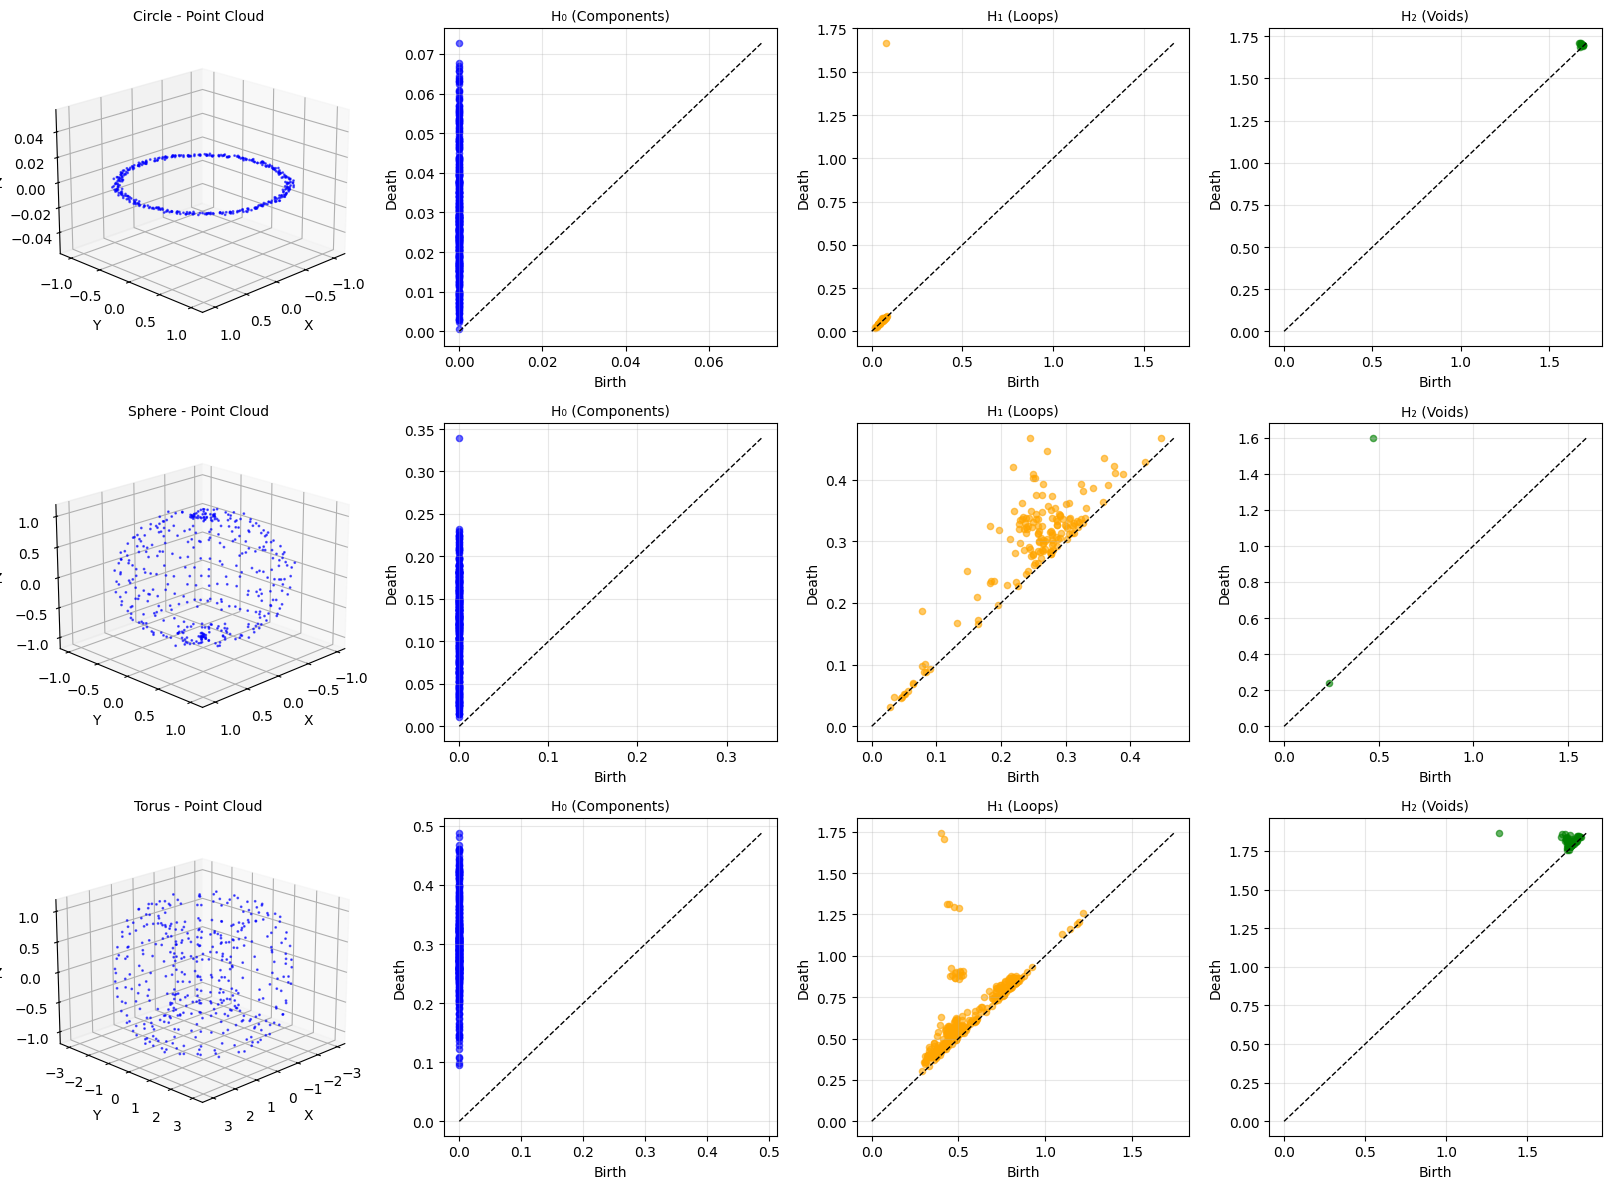


Using device: cuda

Training and Analyzing MLP Model
Epoch 01: train_loss=1.0737, train_acc=0.300 | val_loss=1.0034, val_acc=0.467
Epoch 05: train_loss=0.8230, train_acc=0.667 | val_loss=0.6715, val_acc=0.667
Epoch 10: train_loss=0.2220, train_acc=1.000 | val_loss=0.1427, val_acc=1.000
Epoch 15: train_loss=0.0069, train_acc=1.000 | val_loss=0.0048, val_acc=1.000
Epoch 20: train_loss=0.0020, train_acc=1.000 | val_loss=0.0017, val_acc=1.000

Some validation predictions (true, pred):
true=0, pred=0
true=0, pred=0
true=2, pred=2
true=2, pred=2
true=1, pred=1
true=0, pred=0
true=2, pred=2
true=1, pred=1
true=0, pred=0
true=0, pred=0

Finding minimal perturbation for a TORUS sample (MLP model) with iterative attack...
Original label          : 2 (torus)
Clean prediction        : 2
Adversarial prediction  : 1
Minimal epsilon (L_inf) along this path: 0.7250


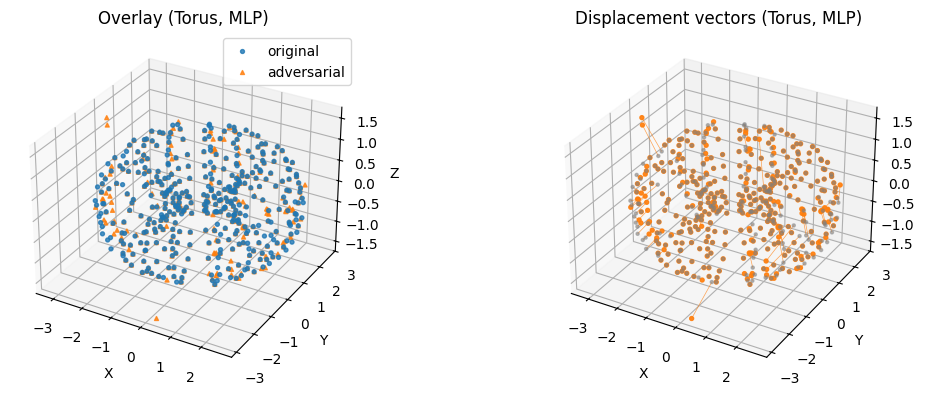

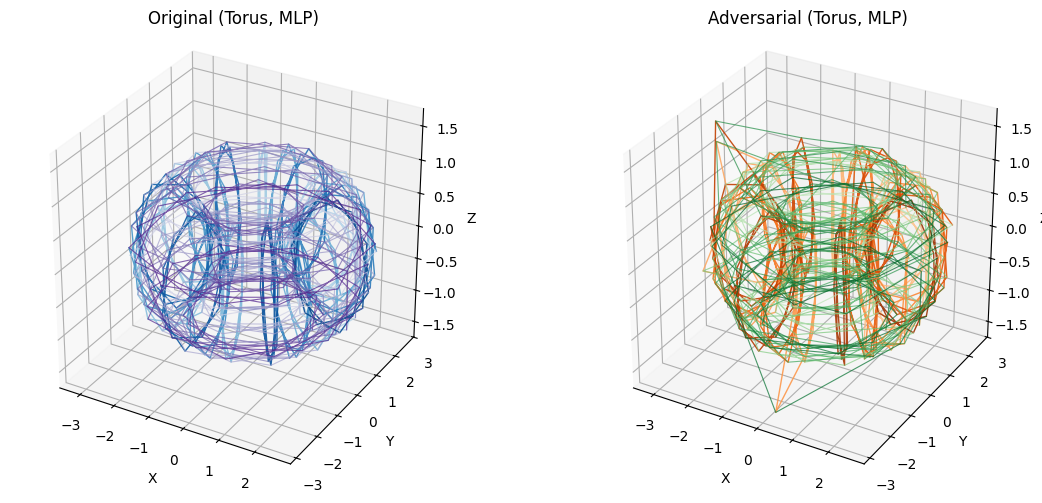


Analyzing layer topology for MLP...


/usr/local/lib/python3.12/dist-packages/ripser/ripser.py:253: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/ripser/ripser.py:253: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(



Topology Statistics per Layer:

input:
  H0_count: 199.0000
  H0_max_persistence: 1.1903
  H0_mean_persistence: 0.3290
  H0_total_persistence: 65.4624
  H1_count: 39.0000
  H1_max_persistence: 0.8143
  H1_mean_persistence: 0.2009
  H1_total_persistence: 7.8558

fc1:
  H0_count: 199.0000
  H0_max_persistence: 1.8021
  H0_mean_persistence: 0.5465
  H0_total_persistence: 108.7448
  H1_count: 44.0000
  H1_max_persistence: 1.2947
  H1_mean_persistence: 0.3024
  H1_total_persistence: 13.4089

fc2:
  H0_count: 199.0000
  H0_max_persistence: 2.3634
  H0_mean_persistence: 0.6005
  H0_total_persistence: 119.5000
  H1_count: 47.0000
  H1_max_persistence: 1.4608
  H1_mean_persistence: 0.2902
  H1_total_persistence: 13.5905

fc3:
  H0_count: 199.0000
  H0_max_persistence: 2.6529
  H0_mean_persistence: 0.6670
  H0_total_persistence: 132.7244
  H1_count: 40.5000
  H1_max_persistence: 1.6520
  H1_mean_persistence: 0.2839
  H1_total_persistence: 11.4689

pooled:
  H0_count: 14.0000
  H0_max_persistenc

/usr/local/lib/python3.12/dist-packages/ripser/ripser.py:253: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(


Saved layer topology visualization to 'MLP_layer_topology.png'

Training and Analyzing CNN Model
Epoch 01: train_loss=1.0867, train_acc=0.475 | val_loss=1.0411, val_acc=0.467
Epoch 05: train_loss=0.8934, train_acc=0.667 | val_loss=0.7635, val_acc=0.667
Epoch 10: train_loss=0.2588, train_acc=1.000 | val_loss=0.1654, val_acc=1.000
Epoch 15: train_loss=0.0068, train_acc=1.000 | val_loss=0.0045, val_acc=1.000
Epoch 20: train_loss=0.0014, train_acc=1.000 | val_loss=0.0012, val_acc=1.000

Some validation predictions (true, pred):
true=0, pred=0
true=0, pred=0
true=2, pred=2
true=2, pred=2
true=1, pred=1
true=0, pred=0
true=2, pred=2
true=1, pred=1
true=0, pred=0
true=0, pred=0

Finding minimal perturbation for a TORUS sample (CNN model) with iterative attack...
Original label          : 2 (torus)
Clean prediction        : 2
Adversarial prediction  : 1
Minimal epsilon (L_inf) along this path: 0.8000


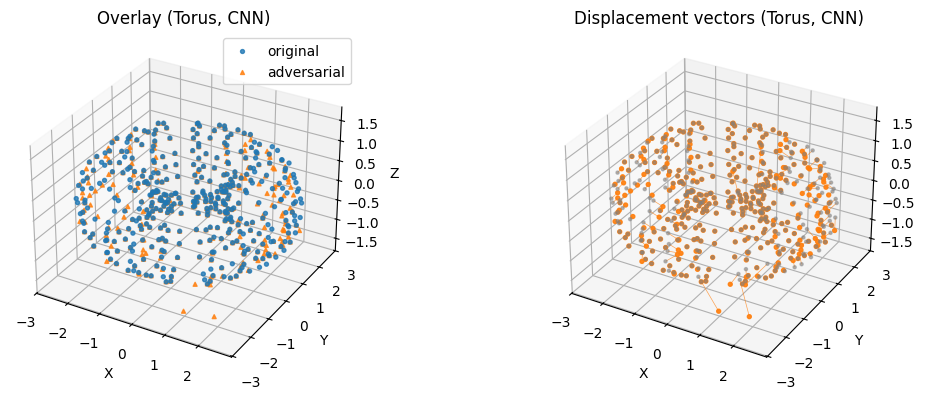

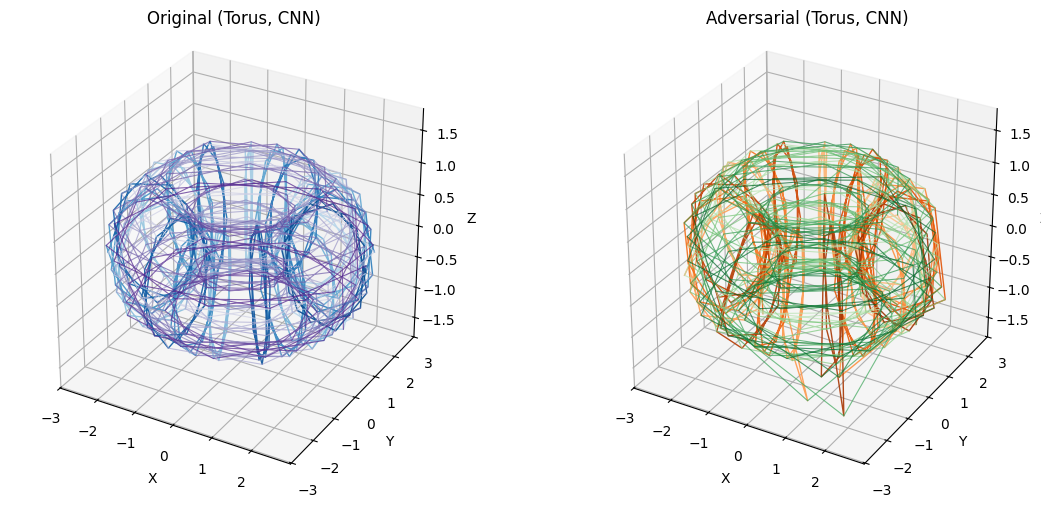


Analyzing layer topology for CNN...


/usr/local/lib/python3.12/dist-packages/ripser/ripser.py:253: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/ripser/ripser.py:253: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(



Topology Statistics per Layer:

input:
  H0_count: 199.0000
  H0_max_persistence: 1.2757
  H0_mean_persistence: 0.3226
  H0_total_persistence: 64.1994
  H1_count: 39.5000
  H1_max_persistence: 0.7230
  H1_mean_persistence: 0.2014
  H1_total_persistence: 7.7745

conv1:
  H0_count: 199.0000
  H0_max_persistence: 1.9028
  H0_mean_persistence: 0.5294
  H0_total_persistence: 105.3432
  H1_count: 41.0000
  H1_max_persistence: 1.2882
  H1_mean_persistence: 0.2781
  H1_total_persistence: 11.3988

conv2:
  H0_count: 199.0000
  H0_max_persistence: 2.5025
  H0_mean_persistence: 0.6354
  H0_total_persistence: 126.4432
  H1_count: 41.5000
  H1_max_persistence: 1.7736
  H1_mean_persistence: 0.4160
  H1_total_persistence: 16.5452

conv3:
  H0_count: 199.0000
  H0_max_persistence: 2.5323
  H0_mean_persistence: 0.6795
  H0_total_persistence: 135.2199
  H1_count: 33.5000
  H1_max_persistence: 2.3300
  H1_mean_persistence: 0.4482
  H1_total_persistence: 15.0146

pooled:
  H0_count: 14.0000
  H0_max_pers

/usr/local/lib/python3.12/dist-packages/ripser/ripser.py:253: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(


Saved layer topology visualization to 'CNN_layer_topology.png'

Analysis complete!


In [ ]:
if __name__ == "__main__":
    main()
